# Linkage manual review dataset — Elasticsearch candidates with controlled rank sampling

Este notebook cria, a partir de um DataFrame Spark com atributos de linkage, uma coluna:

- `es_candidates`: lista (array) com até **N** candidatos retornados do Elasticsearch (via `_msearch`)
- `target_pos`: posição-alvo sorteada por linha segundo uma **distribuição configurada em YAML**
- `es_candidate`: candidato escolhido de `es_candidates[target_pos-1]` com fallback configurável

Pré-requisitos:
- Cluster Spark disponível
- Acesso ao Elasticsearch (rede + credenciais se necessário)
- Pacotes Python: `pyyaml`, `requests`

> Observação: a abordagem usa `_msearch` para reduzir o overhead (lote por partição).


# Importing libs

## Spark

In [37]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark.sql.types as T
from pyspark.storagelevel import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

## Elasticsearch

In [2]:
import requests
import elasticsearch

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.20) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## General

In [3]:
import json
import os
import yaml
from typing import Iterator, Dict, Any

# Starting spark

In [5]:
spark = SparkSession.builder \
    .appName("TrainDataSet") \
    .master("spark://barravento:7077") \
    .config("spark.jars.packages", "org.elasticsearch:elasticsearch-spark-30_2.12:8.1.3") \
    .config("spark.es.nodes", "barravento,jardimdealah,stellamaris") \
    .config("spark.es.port", "9200") \
    .config("spark.es.nodes.wan.only", "false") \
    .config("spark.es.resource", "db2") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 32) \
    .config("spark.sql.files.maxPartitionBytes", "256m") \
    .getOrCreate()

sc = spark.sparkContext
# just to ensure that 
sc.setCheckpointDir("hdfs://barravento:9000/spark-checkpoints")

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.8/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.elasticsearch#elasticsearch-spark-30_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-121f3851-26e5-410c-91af-0d251d73a62e;1.0
	confs: [default]
	found org.elasticsearch#elasticsearch-spark-30_2.12;8.1.3 in central
	found org.scala-lang#scala-reflect;2.12.8 in central
	found org.slf4j#slf4j-api;1.7.6 in central
	found commons-logging#commons-logging;1.1.1 in central
	found javax.xml.bind#jaxb-api;2.3.1 in central
	found com.google.protobuf#protobuf-java;2.5.0 in central
	found org.apache.spark#spark-yarn_2.12;3.2.0 in central
downloading https://repo1.maven.org/maven2/org/elasticsearch/elasticsearch-spark-30_2.12/8.1.3/elasticsearch-spark-30_2.12-8.1.3.jar ...
	[SUCCESSFUL ] org.elasticsearch#el

In [6]:
sc

<SparkContext master=spark://barravento:7077 appName=TrainDataSet>

In [7]:
spark

# 0) Lembrar de indexar

## Criando 'casca' do indice elasticsearch

In [8]:
ES="http://barravento:9200"
DST="basemaior"

In [9]:
settings = {
  "settings": {
    "number_of_shards": 3,
    "number_of_replicas": 2,
    "refresh_interval": "30s"
  }}

In [10]:
r = requests.put(f"{ES}/{DST}", json=settings)
r.raise_for_status()
print(r.json())

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'basemaior'}


## Lendo arquivo e indexando usando o spark

In [11]:
df_a = spark.read.parquet("hdfs://barravento:9000/data/synthetic-dataset-A.parquet")
df_a.limit(2).toPandas()

,id_cidacs_a,nome_a,nome_mae_a,dt_nasc_a,sexo_a
0,1,YASMIM VITORIA MATIAS FONSECA,TACIANY DOS SANTOS,20071122,2
1,2,PEDRO HENRIQUE MARTINS DE CARVALHO,FRANCILEIDE DOS SANTOS ALVES,20061102,1


In [12]:
(df_a.write
    .format("org.elasticsearch.spark.sql")
    .option("es.nodes", "barravento,jardimdealah,stellamaris")
    .option("es.port", "9200")
    .option("es.resource", DST)
    .option("es.batch.size.entries", "500")
    .option("es.batch.size.bytes", "1mb")
    .option("es.batch.write.retry.count", "10")
    .option("es.batch.write.retry.wait", "10s")
    .option("es.mapping.id", "id_cidacs_a")
    .mode("overwrite")
    .save())

In [42]:
r = requests.get(f"{ES}/{DST}")
r.raise_for_status()
print(r.json())

{'basemaior': {'aliases': {}, 'mappings': {'properties': {'dt_nasc_a': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'id_cidacs_a': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'nome_a': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'nome_mae_a': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'sexo_a': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}, 'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'refresh_interval': '30s', 'number_of_shards': '3', 'provided_name': 'basemaior', 'creation_date': '1769804657931', 'number_of_replicas': '2', 'uuid': '46gVf-LQRzyf8_wd7kpYxQ', 'version': {'created': '8010399'}}}}}


## 1) Configuração YAML (exemplo)

In [43]:
# Ajuste o caminho do YAML conforme seu ambiente (Databricks / Jupyter / filesystem)
yaml_path = "01_sampling_cfg.yaml"  # exemplo Databricks
# yaml_path = "linkage_cfg.yaml"               # exemplo local
print("YAML path:", yaml_path)

YAML path: 01_sampling_cfg.yaml


## 2) Carregar YAML e validar distribuição

In [44]:
cfg = yaml.safe_load(open(yaml_path, "r"))

dist = cfg["sampling"]["position_distribution_pct"]
seed = int(cfg["sampling"].get("seed", 2026))

# valida soma = 100
s = sum(int(v) for v in dist.values())
assert s == 100, f"Distribuição precisa somar 100 (atual: {s})"

max_candidates = int(cfg["query"]["max_candidates"])
fallback_mode = cfg["sampling"]["fallback_when_short"]["mode"]

print("OK! max_candidates =", max_candidates)
print("fallback_mode =", fallback_mode)
print("seed =", seed)

OK! max_candidates = 10
fallback_mode = last_available
seed = 2026


## 3) DataFrame de entrada (exemplo)

In [88]:
df_b = spark.read.parquet("hdfs://barravento:9000/data/synthetic-datasets-b-1000.parquet")
# df_b.limit(2).toPandas()

## 4) Sortear a posição-alvo `target_pos` conforme o YAML

In [46]:
items = sorted([(int(k), int(v)) for k, v in dist.items()], key=lambda x: x[0])

# acumulados em [0,1]
cum = []
acc = 0
for pos, pct in items:
    acc += pct
    cum.append((pos, acc / 100.0))

u = F.rand(seed)

case_expr = None
for pos, thr in cum:
    cond = (u <= F.lit(thr))
    case_expr = F.when(cond, F.lit(pos)) if case_expr is None else case_expr.when(cond, F.lit(pos))
case_expr = case_expr.otherwise(F.lit(items[-1][0]))

df2 = df_b.withColumn("target_pos", case_expr.cast("int"))
df2.select("target_pos").groupBy("target_pos").count().orderBy("target_pos").show()

+----------+-----+
|target_pos|count|
+----------+-----+
|         1|  561|
|         2|  326|
|         3|  102|
|         4|   11|
+----------+-----+



In [47]:
# df_a.limit(5).toPandas()

In [87]:
# df2.limit(5).toPandas()

## 5) Buscar candidatos no Elasticsearch via `_msearch` (por partição)

In [49]:
es_hosts = ["http://barravento:9200/"]
es_index = DST

fields_cfg = cfg["query"]["fields"]
# [{'col': 'nome',
#  'es_field': 'nome',
#  'type': 'match',
#  'fuzziness': 'AUTO',
#  'boost': 3.0,
#  'operator': 'AND'},
# ...}]

src_fields = cfg["query"].get("source_fields", [])
# ['nome', 'nome_mae', 'dt_nasc', 'sexo', 'municipio_res']

def build_es_query(row: Dict[str, Any]) -> Dict[str, Any]:
    should = []
    for f in fields_cfg:
        col = f["col"]
        val = row.get(col)

        if val is None or (isinstance(val, str) and val.strip() == ""):
            continue

        qtype = f["type"]
        es_field = f["es_field"]
        boost = float(f.get("boost", 1.0))

        if qtype == "match":
            clause = {
                "match": {
                    es_field: {
                        "query": val,
                        "boost": boost,
                        "operator": f.get("operator", "OR"),
                        "fuzziness": f.get("fuzziness", "AUTO"),
                    }
                }
            }
        elif qtype == "term":
            clause = {"term": {es_field: {"value": val, "boost": boost}}}
        else:
            raise ValueError(f"Tipo não suportado: {qtype}")

        should.append(clause)

    return {
        "size": max_candidates,
        "_source": src_fields,
        "query": {
            "bool": {
                "should": should,
                "minimum_should_match": 1
            }
        }
    }

cand_schema = T.ArrayType(T.StructType([
    T.StructField("es_id", T.StringType(), True),
    T.StructField("es_score", T.DoubleType(), True),
    T.StructField("es_source", T.StringType(), True),  # JSON compactado (opcional)
]))

out_schema = T.StructType(df2.schema.fields + [
    T.StructField("es_candidates", cand_schema, True),
])

def fetch_partition(rows: Iterator[Any]) -> Iterator[Any]:
    rows_list = list(rows)
    if not rows_list:
        return iter([])

    ndjson_lines = []
    for r in rows_list:
        d = r.asDict(recursive=True)
        header = {"index": es_index}
        query  = build_es_query(d)
        ndjson_lines.append(json.dumps(header))
        ndjson_lines.append(json.dumps(query))

    body = "\n".join(ndjson_lines) + "\n"

    base = es_hosts[0].rstrip("/")
    url = f"{base}/_msearch"

    resp = requests.post(
        url,
        data=body,
        headers={"Content-Type": "application/x-ndjson"},
        timeout=60
    )
    resp.raise_for_status()
    payload = resp.json()

    responses = payload.get("responses", [])
    if len(responses) != len(rows_list):
        raise RuntimeError(f"Resposta do ES desalinhada: {len(responses)} != {len(rows_list)}")

    out = []
    for r, pr in zip(rows_list, responses):
        hits = pr.get("hits", {}).get("hits", [])
        cands = []
        for h in hits:
            cands.append({
                "es_id": h.get("_id"),
                "es_score": float(h.get("_score") or 0.0),
                "es_source": json.dumps(h.get("_source", {}), ensure_ascii=False),
            })
        out.append(tuple(list(r) + [cands]))

    return iter(out)

In [50]:
df3 = df2.rdd.mapPartitions(fetch_partition).toDF(schema=out_schema)
df3.select("target_pos", F.size("es_candidates").alias("n_cands")).show(10, truncate=False)

[Stage 19:>                                                         (0 + 1) / 1]

+----------+-------+
|target_pos|n_cands|
+----------+-------+
|1         |10     |
|2         |10     |
|1         |10     |
|2         |10     |
|1         |10     |
|1         |10     |
|2         |10     |
|3         |10     |
|2         |10     |
|1         |10     |
+----------+-------+
only showing top 10 rows



## 6) Criar `es_candidate` escolhendo a posição sorteada (com fallback)

In [51]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

cand_struct = T.StructType([
    T.StructField("es_id", T.StringType(), True),
    T.StructField("es_score", T.DoubleType(), True),
    T.StructField("es_source", T.StringType(), True),
])

def pick_candidate(cands, target_pos: int):
    if cands is None or len(cands) == 0:
        return None
    idx = (target_pos or 1) - 1
    if idx < len(cands):
        return cands[idx]
    if fallback_mode == "last_available":
        return cands[-1]
    if fallback_mode == "first_available":
        return cands[0]
    return None

pick_udf = F.udf(pick_candidate, cand_struct)

df4 = df3.withColumn("es_candidate", pick_udf(F.col("es_candidates"), F.col("target_pos")))

df4.select(
    "target_pos",
    F.col("es_candidate.es_id").alias("es_id"),
    F.col("es_candidate.es_score").alias("es_score")
).show(20, truncate=False)

[Stage 20:>                                                         (0 + 1) / 1]

+----------+------+---------+
|target_pos|es_id |es_score |
+----------+------+---------+
|1         |788   |43.287285|
|2         |30295 |21.231041|
|1         |2233  |36.965725|
|2         |304214|23.156494|
|1         |8067  |30.362999|
|1         |9977  |42.474846|
|2         |849551|24.375296|
|3         |554290|23.838623|
|2         |5278  |13.01546 |
|1         |18289 |36.503246|
|2         |4446  |21.027302|
|2         |285230|25.888466|
|3         |556685|13.794639|
|1         |25342 |33.19347 |
|1         |27803 |33.212765|
|1         |27822 |26.680187|
|1         |27848 |40.029686|
|1         |32354 |30.194675|
|2         |5796  |18.678766|
|1         |36383 |34.80606 |
+----------+------+---------+
only showing top 20 rows



In [86]:
# df4.limit(4).toPandas()

## 7) Auditoria: distribuição observada e taxa de nulos

In [53]:
aud = (
    df4
    .withColumn("has_candidate", F.col("es_candidate").isNotNull())
    .groupBy("target_pos")
    .agg(
        F.count("*").alias("n"),
        F.sum(F.col("has_candidate").cast("int")).alias("n_with_candidate")
    )
    .withColumn("pct_rows", F.col("n") / F.sum("n").over(Window.partitionBy()) * 100)
    .withColumn("pct_with_candidate", F.col("n_with_candidate") / F.col("n") * 100)
    .orderBy("target_pos")
)

aud.show(50, truncate=False)

df4.select(F.mean(F.col("es_candidate").isNull().cast("int")).alias("null_rate")).show()

26/01/30 20:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

+----------+---+----------------+------------------+------------------+
|target_pos|n  |n_with_candidate|pct_rows          |pct_with_candidate|
+----------+---+----------------+------------------+------------------+
|1         |561|561             |56.10000000000001 |100.0             |
|2         |326|326             |32.6              |100.0             |
|3         |102|102             |10.2              |100.0             |
|4         |11 |11              |1.0999999999999999|100.0             |
+----------+---+----------------+------------------+------------------+



[Stage 25:>                                                         (0 + 1) / 1]

+---------+
|null_rate|
+---------+
|      0.0|
+---------+



In [70]:
df4 = (df4
    .withColumn("es_candidate_id", F.col("es_candidate.es_id").cast("string"))
    .withColumn("es_candidate_score", F.col("es_candidate.es_score").cast("double"))
      )

In [71]:
df_out = df4.join(df_a,
                  on=[df4.es_candidate_id == df_a.id_cidacs_a],
                  how='left')

In [72]:
print(f"Base final tem {df_out.count()} registros")
true_matches = df_out.filter(F.col('id_cidacs_b') == F.col('es_candidate_id')).count()
false_matches = df_out.filter(F.col('id_cidacs_b') != F.col('es_candidate_id')).count()
print(f"Destes, {true_matches} são true matches e {false_matches} são falsos.")

Base final tem 1000 registros


[Stage 55:>                                                         (0 + 1) / 1]

Destes, 449 são true matches e 551 são falsos.


# 8) Escrevendo base de resultado

In [83]:
df_out.repartition(16).write.parquet("hdfs://barravento:9000/data/df_for_manual_review.parquet", mode="overwrite")

# 9) Fazendo algumas inspeções (tentando capturar o "nivel de dificuldade)

In [73]:
# monkey patch do NumPy antes do toPandas()
import numpy as np
if not hasattr(np, "bool"):
    np.bool = bool  # patch para PySpark antigo

sample true: 182 sample false: 41


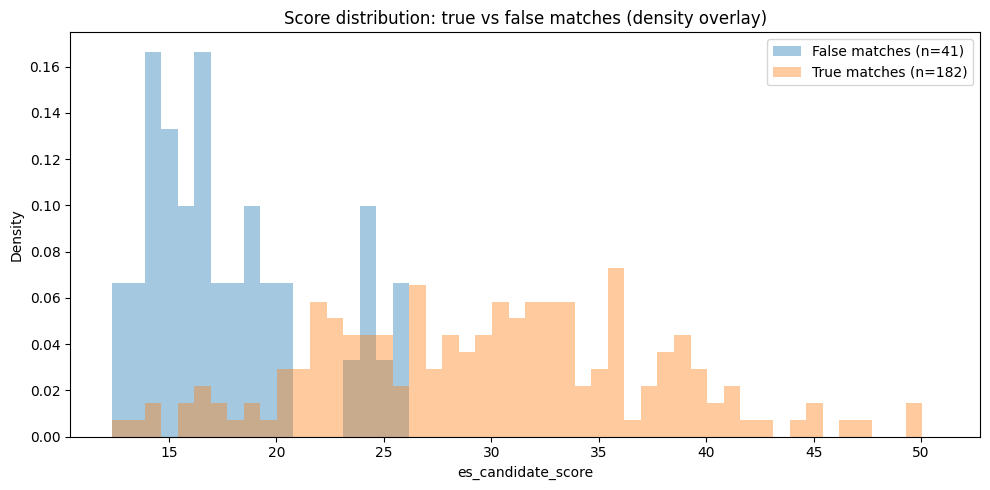

In [74]:
plot_df = (
    df_out
    .select(
        F.col("es_candidate_score").cast("double").alias("score"),
        (F.col("id_cidacs_b").cast("string") == F.col("es_candidate_id").cast("string")).alias("is_true_match")
    )
    .where(F.col("score").isNotNull())
)

# amostra para plot (ajuste a fração)
plot_pd = plot_df.sample(False, 0.2, seed=2026).toPandas()

true_scores  = plot_pd.loc[plot_pd["is_true_match"] == True,  "score"].to_numpy()
false_scores = plot_pd.loc[plot_pd["is_true_match"] == False, "score"].to_numpy()

print("sample true:", true_scores.size, "sample false:", false_scores.size)


import numpy as np
import matplotlib.pyplot as plt

all_scores = plot_pd["score"].to_numpy()

# eixo robusto (evita outliers estourando o gráfico)
q01, q99 = np.quantile(all_scores, [0.01, 0.99])
xmin, xmax = float(q01), float(q99)

bins = 50
edges = np.linspace(xmin, xmax, bins + 1)

plt.figure(figsize=(10, 5))
plt.hist(false_scores, bins=edges, density=True, alpha=0.4, label=f"False matches (n={false_scores.size})")
plt.hist(true_scores,  bins=edges, density=True, alpha=0.4, label=f"True matches (n={true_scores.size})")

plt.xlabel("es_candidate_score")
plt.ylabel("Density")
plt.title("Score distribution: true vs false matches (density overlay)")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
plot_df = (
    df_out
    .select(
        F.col("es_candidate_score").cast("double").alias("score"),
        (F.col("id_cidacs_b").cast("string") == F.col("es_candidate_id").cast("string")).cast("int").alias("is_true_match")
    )
    .where(F.col("score").isNotNull())
)

plot_pd = plot_df.sample(False, 0.2, seed=2026).toPandas()

true_scores  = plot_pd.loc[plot_pd["is_true_match"] == 1, "score"].to_numpy()
false_scores = plot_pd.loc[plot_pd["is_true_match"] == 0, "score"].to_numpy()

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

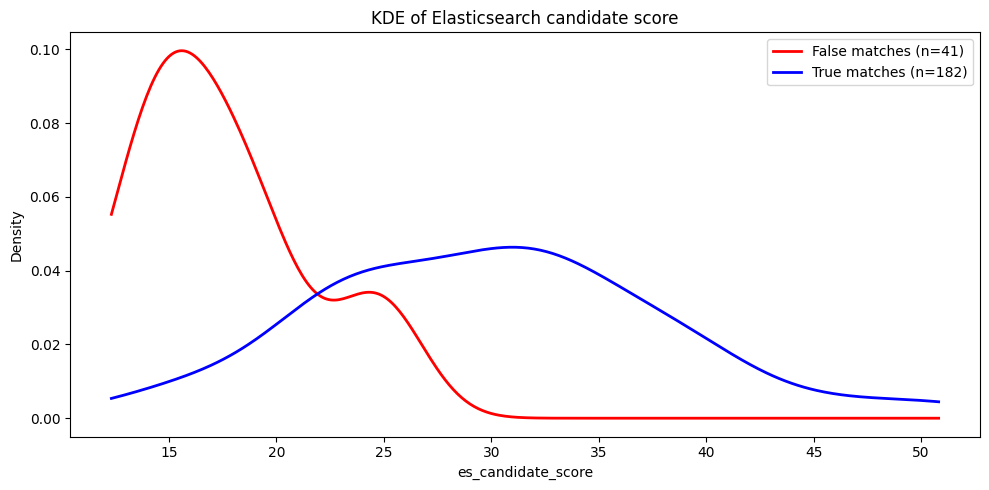

In [79]:
# eixo comum (robusto contra outliers)
all_scores = np.concatenate([true_scores, false_scores])
xmin, xmax = np.quantile(all_scores, [0.01, 0.99])
xs = np.linspace(xmin, xmax, 400)

kde_true  = gaussian_kde(true_scores)
kde_false = gaussian_kde(false_scores)

plt.figure(figsize=(10, 5))
plt.plot(xs, kde_false(xs), color="red",  lw=2, label=f"False matches (n={false_scores.size})")
plt.plot(xs, kde_true(xs),  color="blue", lw=2, label=f"True matches (n={true_scores.size})")

plt.xlabel("es_candidate_score")
plt.ylabel("Density")
plt.title("KDE of Elasticsearch candidate score")
plt.legend()
plt.tight_layout()
plt.show()

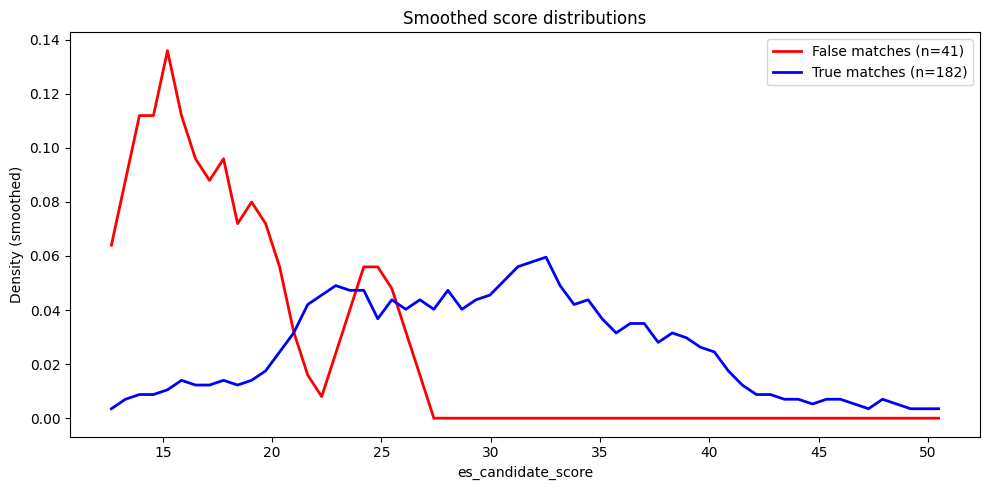

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_hist(scores, bins, xmin, xmax, window=5):
    hist, edges = np.histogram(scores, bins=bins, range=(xmin, xmax), density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    kernel = np.ones(window) / window
    smooth = np.convolve(hist, kernel, mode="same")
    return centers, smooth

all_scores = np.concatenate([true_scores, false_scores])
xmin, xmax = np.quantile(all_scores, [0.01, 0.99])

bins = 60
x_f, y_f = smooth_hist(false_scores, bins, xmin, xmax)
x_t, y_t = smooth_hist(true_scores,  bins, xmin, xmax)

plt.figure(figsize=(10,5))
plt.plot(x_f, y_f, color="red",  lw=2, label=f"False matches (n={false_scores.size})")
plt.plot(x_t, y_t, color="blue", lw=2, label=f"True matches (n={true_scores.size})")

plt.xlabel("es_candidate_score")
plt.ylabel("Density (smoothed)")
plt.title("Smoothed score distributions")
plt.legend()
plt.tight_layout()
plt.show()